In [61]:
%load_ext autoreload
%autoreload 2
%matplotlib inline


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [62]:
import os
import numpy as np
from scipy.spatial import ConvexHull
import torch

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.path import Path
import matplotlib.patches as patches

from lib.utils.visualization import group_by_label_mean, calculate_inertia


In [63]:
DSET = "telecom_italia"
CAP = 1.1
DATA_PTH = f"data/CCP/benchmark/{DSET}/data_norm_cap{CAP}_.dat"
COLS = ["num_users", "x_coord", "y_coord", "normalized_workload"]
SAVE_DIR = "plot_data/"

SAMPLING_METHOD = "quadrant_rnd"
SEED = 1
N = 200

In [64]:
data = torch.load(DATA_PTH)
print(len(data))
xyw = data[:, 1:]

2020


In [75]:
def sub_sample(
    xyw: np.ndarray,
    n: int,
    rng: np.random.RandomState,
    p_size: int = 80,
    lw: int = 2,
    save_dir = None,
):
    # localized sub-sampling based on square
    coords = xyw[:, :2]
    x_min = coords[:, 0].min()
    x_med = np.median(coords[:, 0])
    x_max = coords[:, 0].max()
    y_min = coords[:, 1].min()
    y_med = np.median(coords[:, 1])
    y_max = coords[:, 1].max()
    low = np.array([x_min, y_min])
    high = np.array([x_med, y_med])
    valid = False

    sns.set_theme(style="white", palette=None)
    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))
    ax = axs
    ax.scatter(x=xyw[:, 0], y=xyw[:, 1], marker=".", c="blue", alpha=0.4, s=p_size)

    #xyw_sample = None
    while not valid:
        # sample square seed point (lower left corner quadrant)
        seed_x, seed_y = rng.uniform(low=low, high=high)
        # create square
        seed_x_max = min(seed_x + x_med, x_max)
        seed_y_max = min(seed_y + y_med, y_max)
        square = Path([     # type: ignore
            (seed_x, seed_y), (seed_x, seed_y_max),
            (seed_x_max, seed_y_max), (seed_x_max, seed_y), (seed_x, seed_y)
        ])
        square_idx = square.contains_points(coords)
        square_xyw = xyw[square_idx]
        square_idx_range = np.arange(len(square_xyw))
        # sample randomly from square
        if len(square_idx_range) > n:
            rnd_idx = rng.choice(square_idx_range, size=n, replace=False)
            xyw_sample = square_xyw[rnd_idx]
            valid = True

            patch = patches.PathPatch(square, facecolor="none", lw=lw, edgecolor="black")
            ax.add_patch(patch)
            ax.scatter(x=xyw_sample[:, 0], y=xyw_sample[:, 1],
                       marker="h", c="red", alpha=1.0, s=int(p_size*0.7))

    fig.tight_layout()
    if save_dir is None:
        plt.show()
    else:   # save figure
        save_pth = os.path.join(save_dir, f"subsample_plot.pdf")
        plt.savefig(fname=save_pth, format="pdf", bbox_inches='tight')



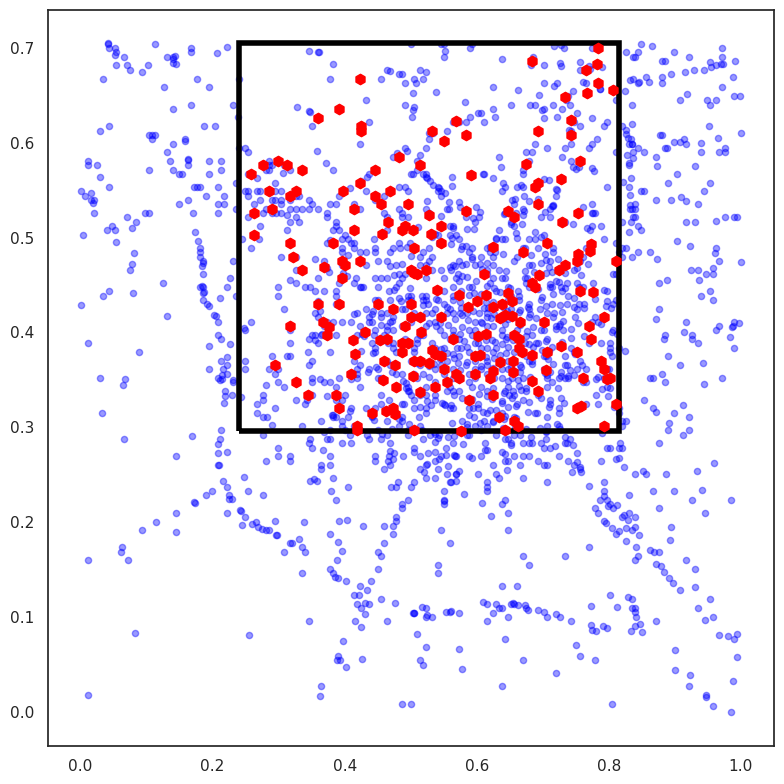

In [76]:
rng = np.random.RandomState(SEED)
sub_sample(xyw, n=N, rng=rng, p_size=80, lw=4, save_dir=SAVE_DIR)
